# Diffusion of ions across a membrane
In this notebook, we construct a bond graph model of ion diffusion across the membrane. The model accounts for the interplay between chemical and electrical energy such systems.

In [1]:
import BondGraphTools as bgt
import numpy as np
from matplotlib import pyplot as plt

from general import mpl_settings, save_figure
from plot_options import set_color_palette

In [2]:
mpl_settings()
set_color_palette()

Assuming that the diffusion of a charged ion across the membrane follows the barrier model, ion diffusion can be represented by the bond graph below.

<img src="electrodiffusion.png" alt="drawing" width="400"/>

We use a function to construct this bond graph in the code below.

In [3]:
R = 8.314
T = 310.0
F = 96485.

def ion_pore(z,conc_ex,conc_in,Ke=1,Ki=1,r=1e-7):
    model = bgt.new(name="Ion pore")
    # Se:Ie
    ion_ex = bgt.new("Se",name="Ie",
                     value=R*T*np.log(Ke*conc_ex)) 
    # Se:Ii
    ion_in = bgt.new("Se",name="Ii",
                     value=R*T*np.log(Ki*conc_in)) 
    flow_f = bgt.new("1",name="f")
    flow_r = bgt.new("1",name="r")
    # Re:pore
    r_pore = bgt.new("Re",name="pore",
                     library="BioChem",
                     value={"r":r,"R":R,"T":T}) 
    # C:mem
    membrane = bgt.new("C",name="mem",value=1.0)
    potential_mem = bgt.new("0",name="mem")
    TF_F = bgt.new("TF",name="F",value=F)
    # TF:-z/2
    TF_z1 = bgt.new("TF",name="zf",value=-z/2)
    # TF:z/2
    TF_z2 = bgt.new("TF",name="zr",value=z/2)
    bgt.add(model,ion_ex,ion_in,flow_f,flow_r,
            r_pore,membrane,potential_mem,
            TF_F,TF_z1,TF_z2)

    bgt.connect(ion_ex,flow_f)
    bgt.connect(flow_f,r_pore)
    bgt.connect(r_pore,flow_r)
    bgt.connect(flow_r,ion_in)
    bgt.connect(potential_mem,(TF_F,1))
    bgt.connect((TF_F,0),membrane)
    bgt.connect(potential_mem,(TF_z1,0))
    bgt.connect((TF_z1,1),flow_f)
    bgt.connect(flow_r,(TF_z2,1))
    bgt.connect((TF_z2,0),potential_mem)
    return model

Models of transport for sodium, potassium and chloride ions can be constructed by passing physiological concentrations and ionic charges $z$ into the function.

In [4]:
Nae = 155/1000
Nai = 19/1000
zNa = 1

Ke = 5/1000
Ki = 136/1000
zK = 1

Cle = 112/1000
Cli = 78/1000
zCl = -1

Na_model = ion_pore(z=zNa,conc_ex=Nae,conc_in=Nai)
K_model = ion_pore(z=zK,conc_ex=Ke,conc_in=Ki)
Cl_model = ion_pore(z=zCl,conc_ex=Cle,conc_in=Cli)

In the code below, the effect of membrane potential on reaction affinity is plotted. The equilibrium points correspond to the Nernst potentials.

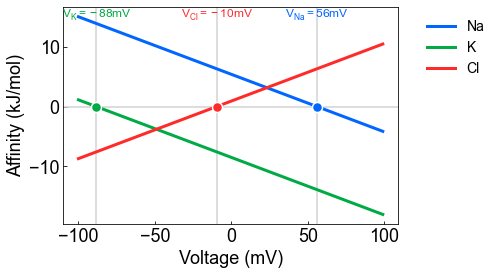

In [5]:
def affinity(V,z,Ie,Ii):
    return R*T*np.log(Ie/Ii) - z*F*V

def nernst(z,Ie,Ii):
    return (R*T/z/F)*np.log(Ie/Ii)

array_V = np.arange(-0.1,0.1,0.001)
A_Na = np.array([affinity(V,zNa,Nae,Nai) for V in array_V])
A_K = np.array([affinity(V,zK,Ke,Ki) for V in array_V])
A_Cl = np.array([affinity(V,zCl,Cle,Cli) for V in array_V])

V_Na = 1000*nernst(zNa,Nae,Nai)
V_K = 1000*nernst(zK,Ke,Ki)
V_Cl = 1000*nernst(zCl,Cle,Cli)

fig_affinity,ax = plt.subplots()
ax.axhline(0, color='lightgray', linewidth=1.5)
ax.axvline(V_Na, color='lightgray', linewidth=1.5)
ax.axvline(V_K, color='lightgray', linewidth=1.5)
ax.axvline(V_Cl, color='lightgray', linewidth=1.5)
plt.plot(1000*array_V,A_Na/1000,label="Na")
plt.plot(1000*array_V,A_K/1000,label="K")
plt.plot(1000*array_V,A_Cl/1000,label="Cl")
plt.xlabel("Voltage (mV)")
plt.ylabel("Affinity (kJ/mol)")
plt.plot(V_Na,0,".",color="C0",markersize=20,markeredgewidth=1.5,markeredgecolor="w")
plt.plot(V_K,0,".",color="C1",markersize=20,markeredgewidth=1.5,markeredgecolor="w")
plt.plot(V_Cl,0,".",color="C2",markersize=20,markeredgewidth=1.5,markeredgecolor="w")
ax.annotate("$\mathregular{V_{Na} = 56mV}$",xy=(V_Na,15),
            fontsize=12,color="C0",horizontalalignment='center')
ax.annotate("$\mathregular{V_{K} = -88mV}$",xy=(V_K,15),
            fontsize=12,color="C1",horizontalalignment='center')
ax.annotate("$\mathregular{V_{Cl} = -10mV}$",xy=(V_Cl,15),
            fontsize=12,color="C2",horizontalalignment='center')
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.show()

Simulations of the model are run below. The final voltages correspond to the Nernst potentials once again.

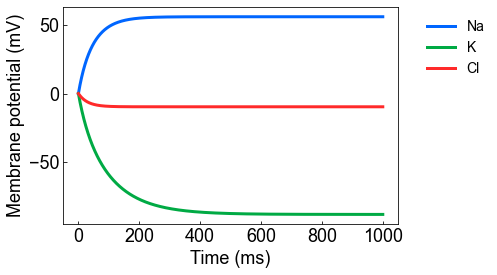

In [6]:
tspan = (0.0,1000.0)
x0 = [0.0]

t,V_Na = bgt.simulate(Na_model,tspan,x0)
t,V_K = bgt.simulate(K_model,tspan,x0)
t,V_Cl = bgt.simulate(Cl_model,tspan,x0)

fig_flux = plt.figure()
plt.plot(t,1000*V_Na)
plt.plot(t,1000*V_K)
plt.plot(t,1000*V_Cl)
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.legend(["Na","K","Cl"],bbox_to_anchor=(1.05, 1.0))
plt.show()

The code below saves the figures in this notebook

In [7]:
save_figure(fig_affinity,"output/ion_affinity")
save_figure(fig_flux,"output/ion_flux")